# Hierarchical agglomerative clustering (Above-phoneme)

### Collect training features

In [17]:
import numpy as np
import random
import os, sys
import matplotlib.pyplot as plt
import warnings
from lib.esn import ESN
from dataset.loading import DataLoader

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

path = '../../data/'
fc = DataLoader(path)

dr = []
speakers = []
XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features, labels, _ = fc.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


In [18]:
from dataset.data_helpers import *

selected_labels = None
#selected_labels = ["aa", "b", "s", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh", "er", "ey", "ix", "aw", "axr", "l", "oy", "r", "y"]

phonemes, features, labels = filter_data(features, labels, selected_labels=selected_labels, limit=None)
group = group_by_labels(features, labels)
n_samples = len(features)
n_classes = len(phonemes)

print(f"{str(n_classes)} phonemes: {phonemes}")

Filtered to 177080 samples of shape (10, 14)
39 phonemes: ['h#', 'w', 'ih', 's', 'ah', 'ch', 'n', 'ae', 't', 'v', 'r', 'f', 'y', 'uw', 'sh', 'l', 'b', 'iy', 'aa', 'd', 'eh', 'p', 'z', 'ey', 'dx', 'ay', 'ng', 'k', 'dh', 'er', 'm', 'jh', 'g', 'ow', 'aw', 'hh', 'uh', 'oy', 'th']


In [19]:
# init reservoir

esn_params = {
    "in_dim": n_mels,
    "out_dim": n_mels,
    "N": 10,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5,
    "weights": .1
}

esn = ESN(esn_params)

In [20]:
from experiments.helpers.experiment_helpers import *

aperture = "auto"
normalize = True
Cs = compute_Cs(group=group, esn=esn, aperture=aperture, normalize=normalize, XorZ=XorZ, cache=False)

- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  314.92650542480504
normalizing
Target:  6.032545152555168
std 0.15387967236902733


In [25]:
from lib.clustering_metrics import get_heat_map
from lib.clustering_helpers import *

save = False

hm_filename = str(selected_labels)+path_option+XorZ + str(aperture) + str(esn.esn_params) + str(len(group.keys())) + str(len(list(group.values())[0])) + "heatmap"

hm = None
if save:
    hm = try_reading_from_cache(hm_filename)
if hm is None:
    print("- computing heatmap")
    hm = get_heat_map(Cs, similarity_c)
    save_to_cache(hm_filename, hm)
    print("--- Done")

- computing heatmap
--- Done


### Average linkage and plotting of its results

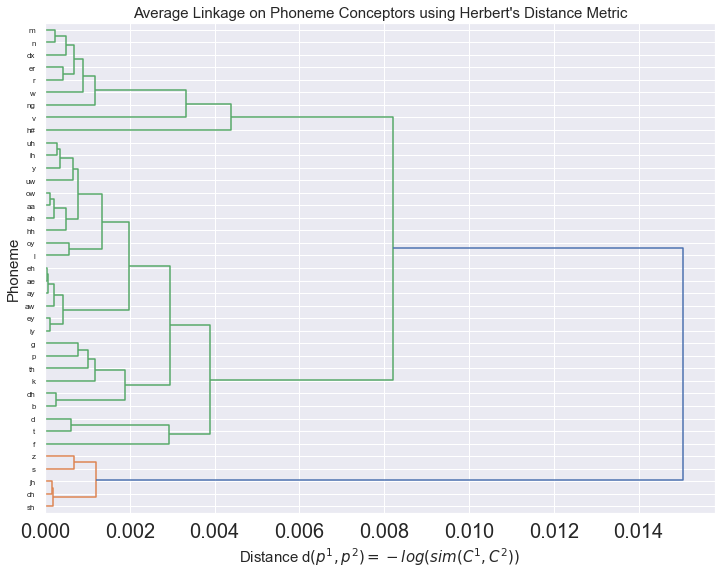

In [26]:
import scipy.cluster.hierarchy as sc
import scipy.spatial.distance as ssd

distArray = ssd.squareform(hm)
#distArray = 1-distArray/np.max(distArray)
distArray = -np.log(distArray)
link = sc.linkage(distArray, method='average', optimal_ordering=False)
#link = sc.linkage(1-distArray/np.max(distArray), method='average', optimal_ordering=False)

# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 9))

D = sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

plt.title("Average Linkage on Phoneme Conceptors using Jaeger's Distance Metric",fontsize=15)
plt.ylabel('Phoneme',fontsize=15)
plt.xlabel(r"Distance d$(p^1, p^2)=-log(sim(C^1,C^2))$",fontsize=15)
plt.show()

### Plot Heatmap

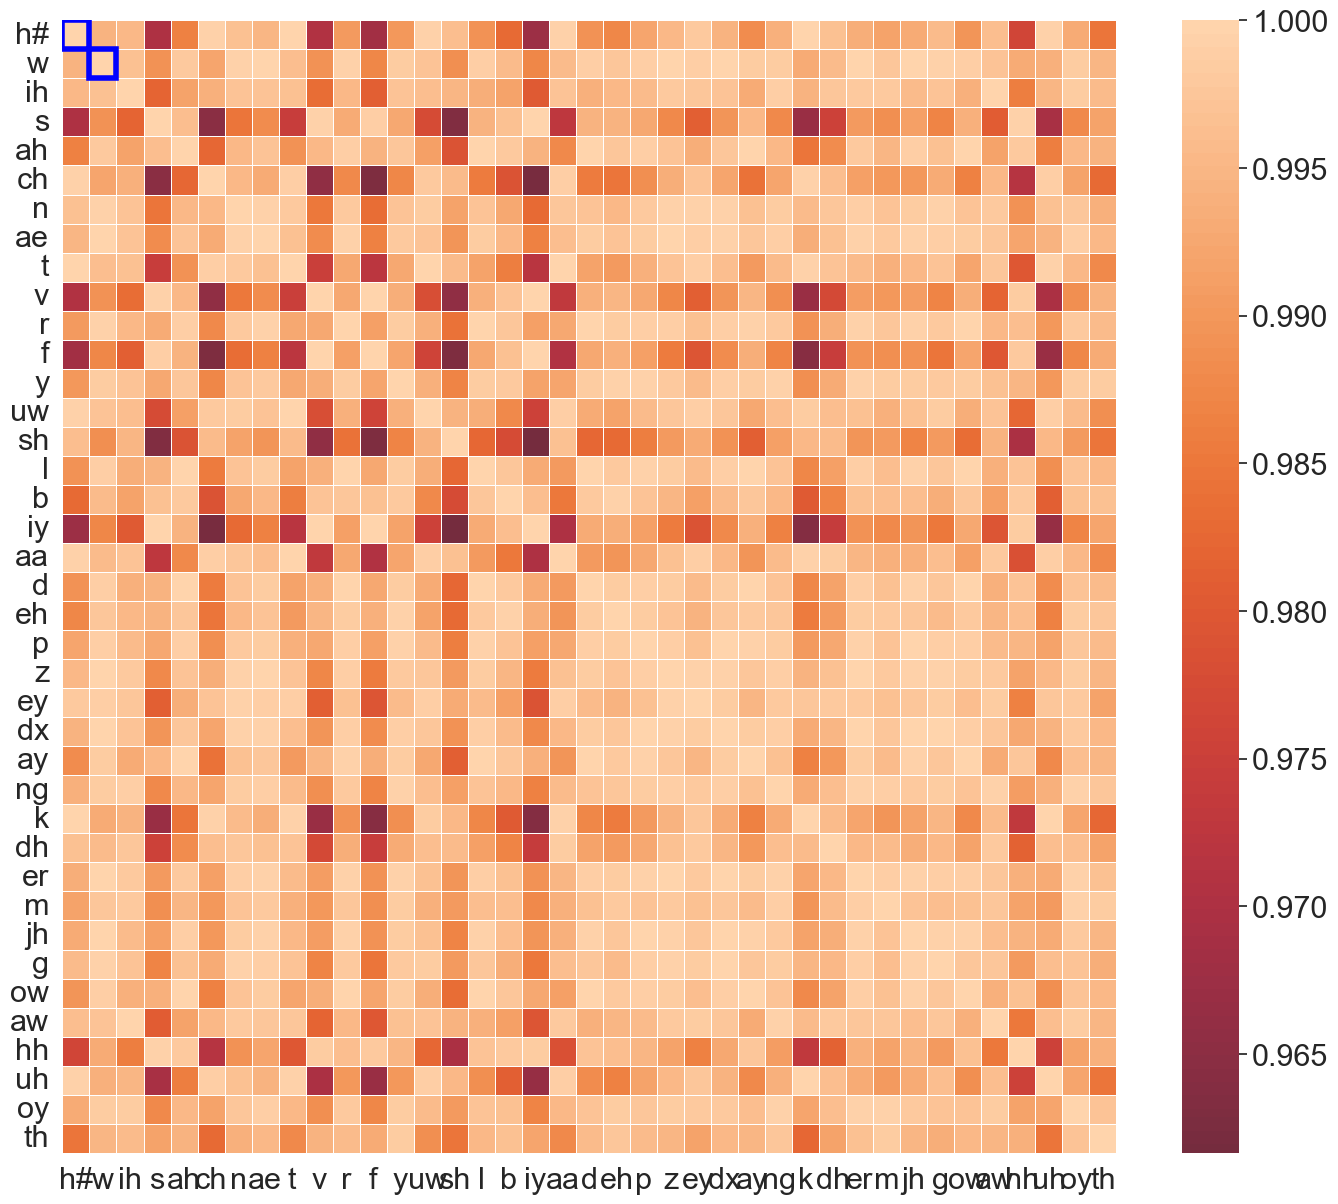

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

np.fill_diagonal(hm, 1)

labs = D["ivl"]
custom_labs = ['h#', 'w', 'ih', 's', 'ah', 'ch', 'n', 'ae', 't', 'v', 'r', 'f', 'y', 'uw', 'sh', 'l', 'b', 'iy', 'aa', 'd', 'eh', 'p', 'z', 'ey', 'dx', 'ay', 'ng', 'k', 'dh', 'er', 'm', 'jh', 'g', 'ow', 'aw', 'hh', 'uh', 'oy', 'th']

reorder = [ labs.index(lab) for lab in custom_labs]
hm = hm[reorder,:]
hm = hm[:,reorder]

plt.figure(figsize=(17,15),dpi=100)
sns.set_theme()
sns.set(font_scale=2)

ax_hm = sns.heatmap(hm, xticklabels=custom_labs, yticklabels=custom_labs, linewidths=.5, center=np.mean(hm)-.05)
plt.rc('xtick', labelsize='20')    # fontsize of the tick labels
plt.rc('ytick', labelsize='20')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Adding coloring to phonetic groups
recs = [
    [0,1],
    [1,1]
]
for rec in recs:
    ax_hm.add_patch(
         patches.Rectangle(
             (rec[0], rec[0]),
             rec[1], rec[1],
             edgecolor='blue',
             fill=False,
             lw=4
         )
    )

plt.show()